# Regresión logística multiclase

La regresión logística es normalmente un modelo de clasificación binaria, es decir, distingue entre dos clases (por ejemplo: "spam" vs "no spam").
Pero si se tienen más de dos clases (por ejemplo, clasificar entre 3 marcas de vehículos), se necesita adaptar el modelo. Aquí es donde entra el enfoque One-vs-Rest:

*¿Cómo funciona One-vs-Rest?*
Suponiendo que se tienen tres clases: A, B y C.
Con One-vs-Rest vas a entrenar un clasificador binario por cada clase:
* Clasificador 1: ¿Es A o no? (A vs B+C)
* Clasificador 2: ¿Es B o no? (B vs A+C)
* Clasificador 3: ¿Es C o no? (C vs A+B)
Cada uno de estos clasificadores se entrena por separado usando regresión logística binaria. Luego, cuando se hace una predicción, cada uno da una probabilidad, y se elige la clase con la mayor probabilidad.

Inicialmente importaremos todas las librerias necesarias para la ejecución de nuestros procesos:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Para poder utilizar sklearn debes instalar scikit-learn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings

# Configurar estilo de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

Ahora cargaremos los datasets que se utilizarán, estos estan en el siguiente orden de carpetas y mostramos los primeros registros del dataset

```bash
|--datasources
   |--parkinsons
```

In [45]:
df = pd.read_csv("./datasources/parkinsons/parkinsons.data")
df = df.drop_duplicates()
df = df.drop(columns=["name"])
df.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


Una vez revisados algunos datos y cargadas las dependencias necesarios, vamos a explorar la información del dataset

In [46]:
print("Información del dataset:")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")
print("\nDistribución de la variable objetivo:")
print(df['status'].value_counts())
print("\nPorcentaje de cada clase:")
print(df['status'].value_counts(normalize=True) * 100)

# Mostrar información sobre los tipos de datos
print("\nTipos de datos en cada columna:")
print(df.dtypes)

# Verificar valores faltantes
print("\nValores faltantes en cada columna:")
print(df.isnull().sum())


Información del dataset:
Número de filas: 195
Número de columnas: 23

Distribución de la variable objetivo:
status
1    147
0     48
Name: count, dtype: int64

Porcentaje de cada clase:
status
1    75.384615
0    24.615385
Name: proportion, dtype: float64

Tipos de datos en cada columna:
MDVP:Fo(Hz)         float64
MDVP:Fhi(Hz)        float64
MDVP:Flo(Hz)        float64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
MDVP:RAP            float64
MDVP:PPQ            float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
MDVP:APQ            float64
Shimmer:DDA         float64
NHR                 float64
HNR                 float64
status                int64
RPDE                float64
DFA                 float64
spread1             float64
spread2             float64
D2                  float64
PPE                 float64
dtype: object

Valores faltantes en cada columna:
MDVP:Fo(Hz)      

Ahora vamos a explorar cada una de las características que podemos encontrar en el dataset en busca de patrones y relaciones en la información

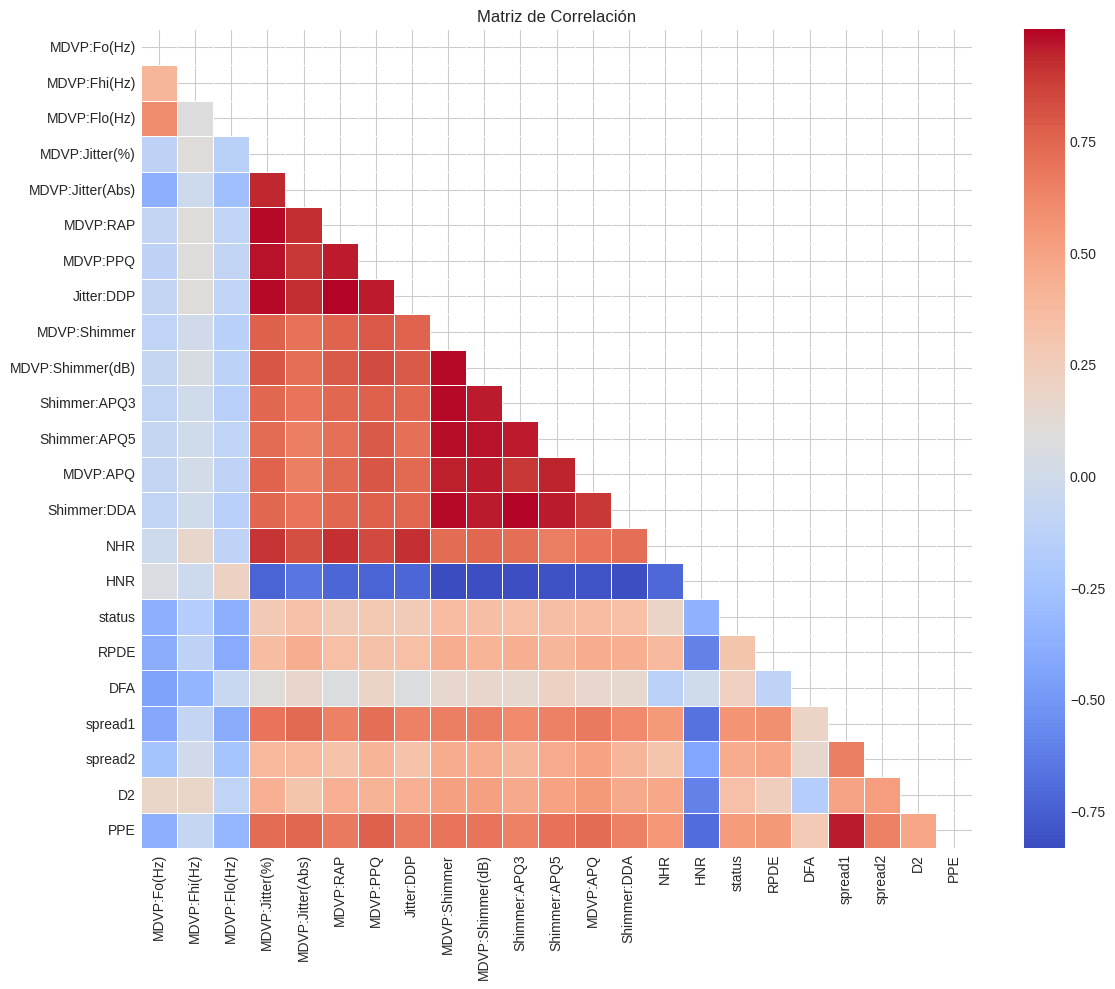

Top 10 características con mayor correlación con 'status':
status              1.000000
spread1             0.564838
PPE                 0.531039
spread2             0.454842
MDVP:Shimmer        0.367430
MDVP:APQ            0.364316
Shimmer:APQ5        0.351148
MDVP:Shimmer(dB)    0.350697
Shimmer:APQ3        0.347617
Shimmer:DDA         0.347608
D2                  0.340232
Name: status, dtype: float64


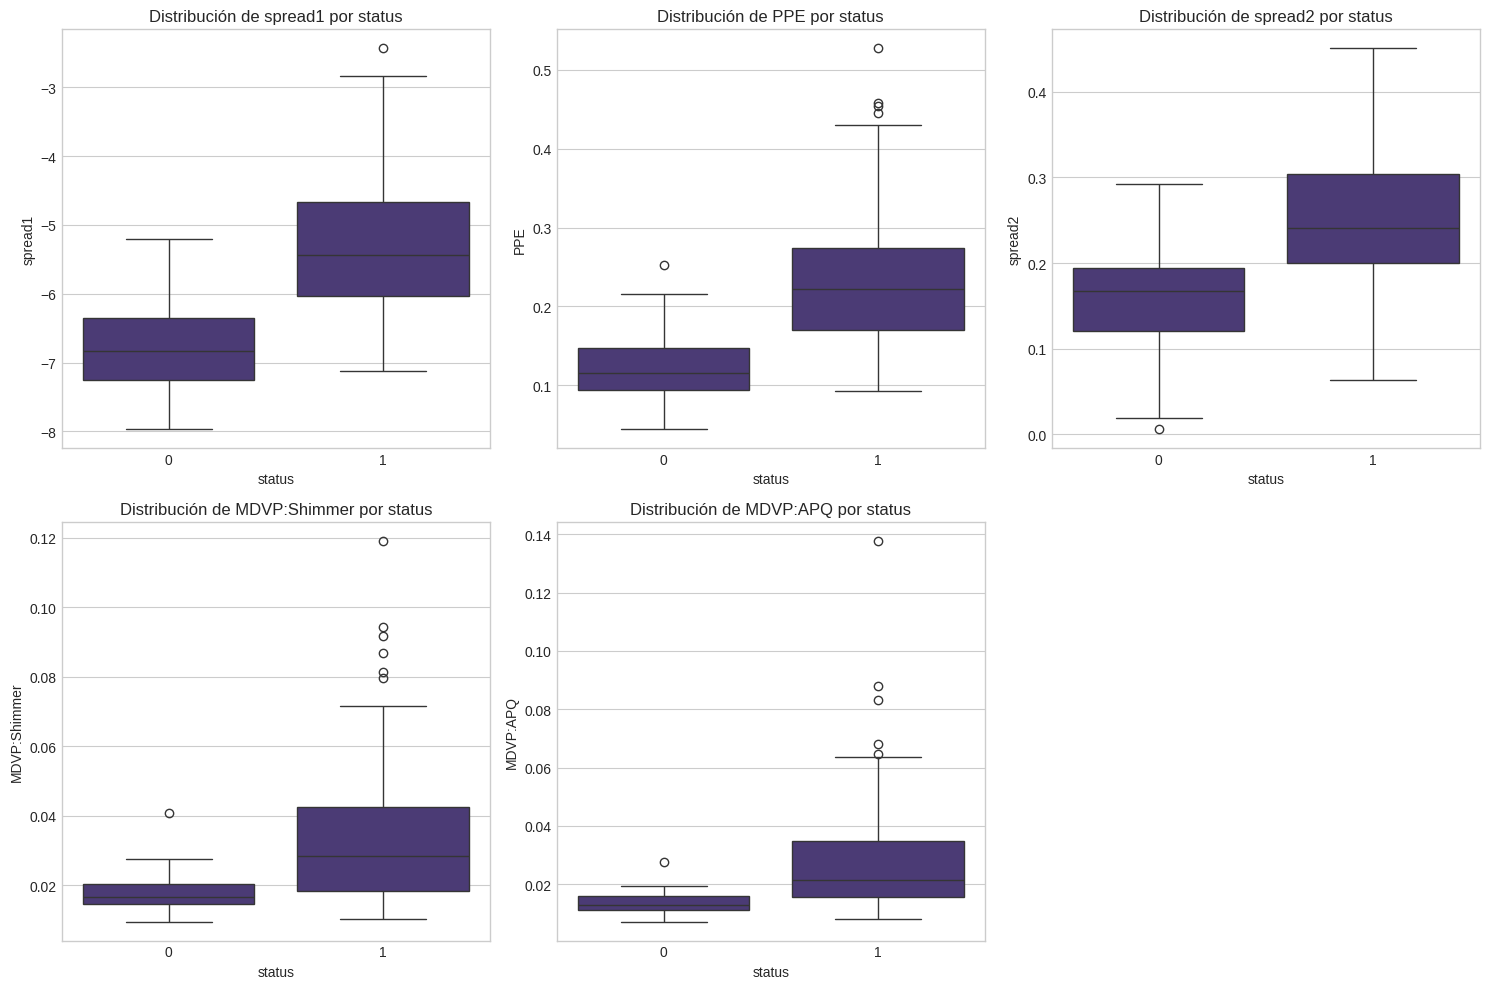

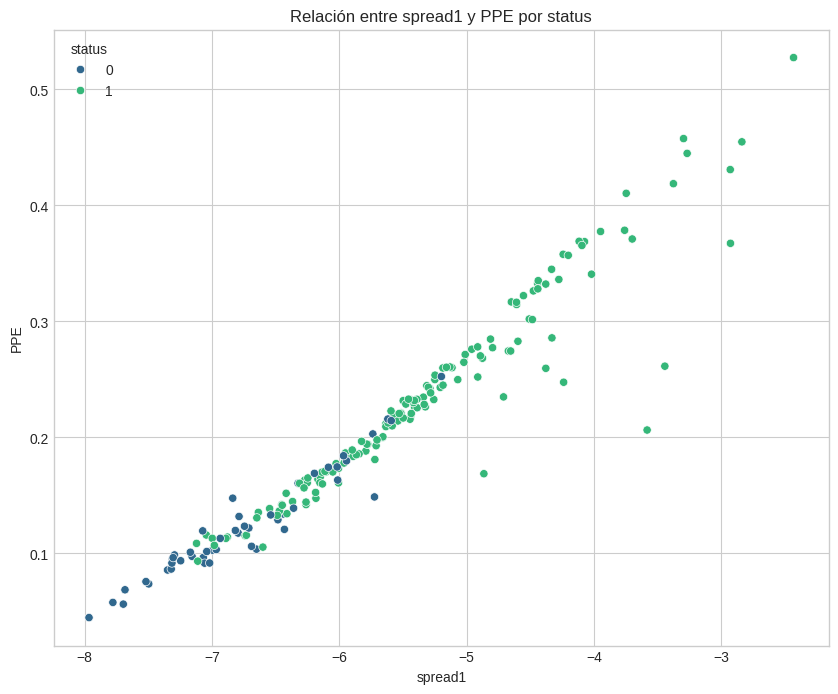

In [47]:
# Estadísticas descriptivas de las columnas numéricas
df.describe().T.sort_values(by='mean', ascending=False)

# Matriz de correlación con la variable objetivo (status)
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=False, mask=mask, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

# Top 10 características con mayor correlación con 'status'
correlations = df.corr()['status'].sort_values(ascending=False)
print("Top 10 características con mayor correlación con 'status':")
print(correlations.head(11))  # 11 porque 'status' también está en la lista

# Distribución de algunas características importantes según su correlación con 'status'
top_features = correlations.index[1:6]  # Excluyendo 'status' mismo

plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='status', y=feature, data=df)
    plt.title(f'Distribución de {feature} por status')
plt.tight_layout()
plt.show()

# Visualizamos la relación entre las dos características más correlacionadas con 'status'
plt.figure(figsize=(10, 8))
sns.scatterplot(x=top_features[0], y=top_features[1], hue='status', data=df, palette='viridis')
plt.title(f'Relación entre {top_features[0]} y {top_features[1]} por status')
plt.show()